In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt

In [3]:
class FashionMNISTSet:
    def __init__(self, dim=(28,28), batch_size=32) -> None:
        composition = transforms.Compose([transforms.Resize(dim), transforms.ToTensor()])
        self.train_set = FashionMNIST(root='./dataset', train=True, download=True, transform=composition)
        self.val_set = FashionMNIST(root='./dataset', train=False, download=True, transform=composition)
        self.batch_size = batch_size
        self.dim = dim
        
    def create_dataloader(self, train: bool):
        """Create a dataloader."""
        if train:
            shuffle = True
            dataset = self.train_set
        else:
            shuffle = False
            dataset = self.val_set
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)
    
    def text_labels(self, indices):
        """Return text labels."""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]
    
    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)

        _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,8))
        
        for i, ax in enumerate(axes.flat):
            ax.imshow(X[i].squeeze(0), cmap='gray')
            ax.set_title(labels[i])
            ax.axis('off')

In [4]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.lin = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.lin(x.reshape(-1, self.input_dim))
    
    def loss(self, yhat, y):
        # Built in softmax capability
        return torch.nn.CrossEntropyLoss()(yhat, y)
    
    def config_optimizer(self, lr):
        self.opt = torch.optim.SGD(self.parameters(), lr=lr)
    
    def train_step(self, batch):
        X, y = batch
        out = self(X)
        loss = self.loss(out, y)
        loss.backward()
        self.opt.step()
        return loss.item()
    
    def val_step(self, batch):
        with torch.no_grad():
            X, y = batch
            out = self(X)
            loss = self.loss(out, y)
            return loss.item()

In [5]:
class Trainer:
    def __init__(self, epochs=10) -> None:
        self.epochs = epochs
        self.tr_loss = []
        self.val_loss = []
        
    def train(self, model, train_loader, val_loader):
        """Train the model."""
        for epoch in range(self.epochs):
            model.train()
            model.opt.zero_grad()
            train_loss = 0
            for batch in train_loader:
                train_loss += model.train_step(batch)
            train_loss /= len(train_loader)
            
            model.eval()
            val_loss = 0
            for batch in val_loader:
                val_loss += model.val_step(batch)
            val_loss /= len(val_loader)

            self.tr_loss.append(train_loss)
            self.val_loss.append(val_loss)
            
            print(f'Epoch: {epoch}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')

In [6]:
dataset = FashionMNISTSet(batch_size=256)
trainer = Trainer(epochs=10)

model = LinearModel(28*28, 10)
model.config_optimizer(lr=0.01)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



In [7]:
print(model)

LinearModel(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)


In [8]:
trainer.train(model, dataset.create_dataloader(train=True), dataset.create_dataloader(train=False))

Epoch: 0, Train Loss: 1.100, Val Loss: 1.281
Epoch: 1, Train Loss: 1.028, Val Loss: 1.050
Epoch: 2, Train Loss: 0.818, Val Loss: 1.060
Epoch: 3, Train Loss: 0.808, Val Loss: 1.094
Epoch: 4, Train Loss: 0.789, Val Loss: 0.902
Epoch: 5, Train Loss: 0.641, Val Loss: 0.764
Epoch: 6, Train Loss: 0.565, Val Loss: 0.657
Epoch: 7, Train Loss: 0.529, Val Loss: 0.667
Epoch: 8, Train Loss: 0.580, Val Loss: 0.736
Epoch: 9, Train Loss: 0.565, Val Loss: 0.666


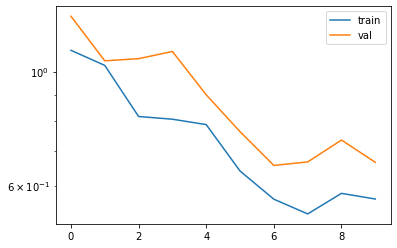

In [9]:
plt.plot(trainer.tr_loss, label='train')
plt.plot(trainer.val_loss, label='val')
plt.yscale('log')
plt.legend()